# Global explanation for white-box and XGBoost model


In [1]:
# Run this for reproduce
# Gets the current working directory
import os
cwd = os.getcwd()
print("Working directory:", cwd)
# Go up one directory from working directory
os.chdir("..")

Working directory: /Users/anhtth/Library/CloudStorage/OneDrive-UniversityofTwente/2023 UT- THESIS/1-Code/0.cb12_main/xai_posthoc


In [2]:
# Import library for baseline classification models
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

In [3]:
from interpret import set_visualize_provider
from interpret.provider import InlineProvider
set_visualize_provider(InlineProvider())

In [4]:
from interpret import show
from interpret.blackbox import LimeTabular

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder
from sklearn import metrics

In [6]:
import matplotlib.pyplot as plt

# Load data

In [8]:
# Load input: train_data_flat, test_data_flat
train_data_flat = pd.read_csv('./xai_posthoc/train_data_flat.csv')
test_data_flat = pd.read_csv('./xai_posthoc/test_data_flat.csv')

In [9]:
drop_cols_flat = ['UserID','JobID', 'label','u_idx','j_idx',
                  'work_history_matrix', 'job_matrix', 
                  'mean_work_history_matrix', 'mean_job_matrix', 
                  'flat_work_history', 'flat_job']
X_train = train_data_flat.drop(columns = drop_cols_flat, axis = 1)
X_test = test_data_flat.drop(columns = drop_cols_flat, axis = 1)

In [10]:
y_train = np.load("./xai_posthoc/y_train_tabular.npy")
y_test = np.load("./xai_posthoc/y_test_tabular.npy")

## 1. Model: logreg

In [7]:
# Load a baseline model
import pickle
model = 'logreg'
model_name = './output_baseline_tabular/cb12_logreg_flat.pikle'
logreg = pickle.load(open(model_name, "rb"))

/Users/anhtth/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [11]:
feature_names = X_train.columns
coefficients = logreg.coef_[0]

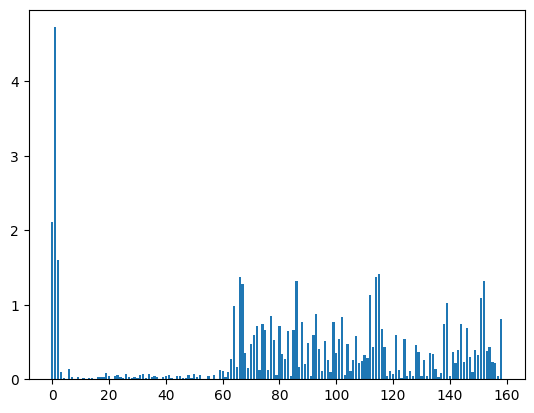

In [12]:
# Plot feature importance: ALL
plt.bar(range(len(coefficients)), abs(coefficients))
plt.show()

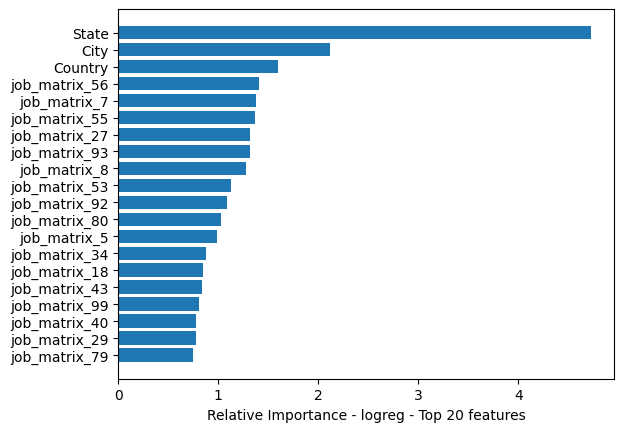

In [16]:
# Plot the customized number of features (if there are too many features)
indices = np.argsort((abs(coefficients)))
num_features = 20
plt.barh(range(num_features), abs(coefficients)[indices[-num_features:]], align='center')
plt.yticks(range(num_features), [feature_names[i] for i in indices[-num_features:]])
plt.xlabel(f'Relative Importance - {model} - Top 20 features')
plt.show()

In [17]:
logreg_fi = pd.DataFrame(columns=['features','abs_coefficients'])

In [18]:
logreg_fi.features = [feature_names[i] for i in indices[-num_features:]]

In [19]:
logreg_fi.abs_coefficients = abs(coefficients)[indices[-num_features:]]

In [20]:
logreg_fi

,features,abs_coefficients
0,job_matrix_79,0.747941
1,job_matrix_29,0.773157
2,job_matrix_40,0.773172
3,job_matrix_99,0.805095
4,job_matrix_43,0.835874
5,job_matrix_18,0.850222
6,job_matrix_34,0.871688
7,job_matrix_5,0.983452
8,job_matrix_80,1.021916
9,job_matrix_92,1.088520


In [21]:
logreg_fi.to_csv('./xai_posthoc/logreg_global_exp.csv', header=True, index=False)

## 2. Model: Decision Tree (DT)

In [22]:
# Load a baseline model
import pickle
model = 'dt'
model_name = './nb_baseline_tabular/cb12_dt_flat.pikle'
dt = pickle.load(open(model_name, "rb"))

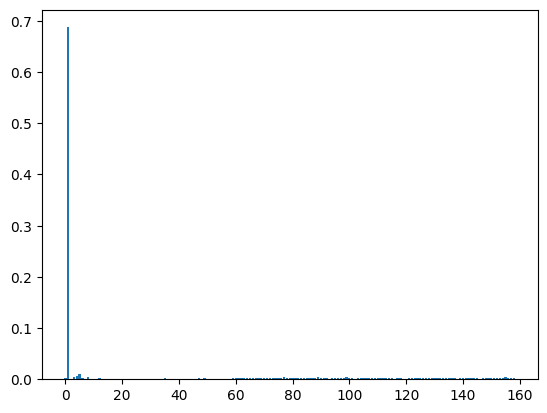

In [23]:
# plot
import matplotlib.pyplot as plt
plt.bar(range(len(dt.feature_importances_)), dt.feature_importances_)
plt.show()

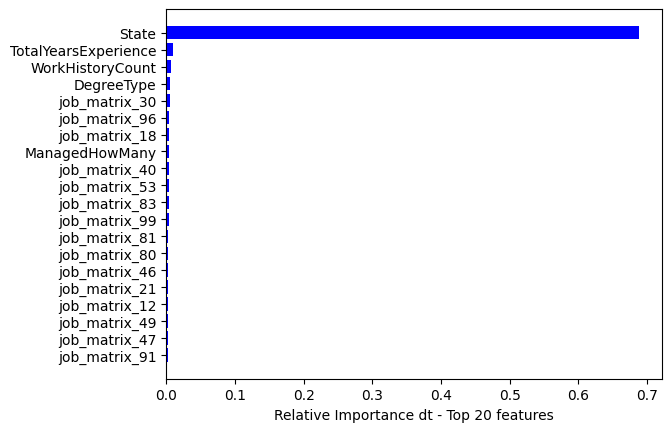

In [24]:
# only plot the customized number of features
importances = dt.feature_importances_
indices = np.argsort(importances)
num_features = 20
plt.barh(range(num_features), importances[indices[-num_features:]], color='b', align='center')
plt.yticks(range(num_features), [feature_names[i] for i in indices[-num_features:]])
plt.xlabel(f'Relative Importance {model} - Top 20 features')
plt.show()

In [25]:
dt_fi = pd.DataFrame(columns=['features','importance'])

In [26]:
dt_fi.features = [feature_names[i] for i in indices[-num_features:]]

In [27]:
dt_fi.importance = importances[indices[-num_features:]]

In [28]:
dt_fi

,features,importance
0,job_matrix_91,0.002942
1,job_matrix_47,0.002951
2,job_matrix_49,0.002974
3,job_matrix_12,0.003091
4,job_matrix_21,0.003219
5,job_matrix_46,0.003235
6,job_matrix_80,0.003260
7,job_matrix_81,0.003283
8,job_matrix_99,0.003354
9,job_matrix_83,0.003441


In [29]:
dt_fi.to_csv('./xai_posthoc/dt_global_exp.csv', header=True, index=False)

### Plot the decision trees

In [30]:
# Get depth level of the tree
from sklearn import tree
dt.tree_.max_depth

109

In [31]:
X_train.columns

Index(['City', 'State', 'Country', 'DegreeType', 'WorkHistoryCount',
       'TotalYearsExperience', 'CurrentlyEmployed', 'ManagedOthers',
       'ManagedHowMany', 'work_matrix_0',
       ...
       'job_matrix_90', 'job_matrix_91', 'job_matrix_92', 'job_matrix_93',
       'job_matrix_94', 'job_matrix_95', 'job_matrix_96', 'job_matrix_97',
       'job_matrix_98', 'job_matrix_99'],
      dtype='object', length=159)

CPU times: user 87.5 ms, sys: 8.3 ms, total: 95.8 ms
Wall time: 95.5 ms


[Text(0.5, 0.9, 'State <= 0.5\ngini = 0.5\nsamples = 563889\nvalue = [281944, 281945]'),
 Text(0.25, 0.7, 'DegreeType <= 3.5\ngini = 0.211\nsamples = 306214\nvalue = [269565, 36649]'),
 Text(0.125, 0.5, 'job_matrix_21 <= 0.024\ngini = 0.175\nsamples = 166268\nvalue = [150178, 16090]'),
 Text(0.0625, 0.3, 'job_matrix_8 <= 0.031\ngini = 0.203\nsamples = 116722\nvalue = [103333, 13389]'),
 Text(0.03125, 0.1, '\n  (...)  \n'),
 Text(0.09375, 0.1, '\n  (...)  \n'),
 Text(0.1875, 0.3, 'job_matrix_15 <= 0.112\ngini = 0.103\nsamples = 49546\nvalue = [46845, 2701]'),
 Text(0.15625, 0.1, '\n  (...)  \n'),
 Text(0.21875, 0.1, '\n  (...)  \n'),
 Text(0.375, 0.5, 'job_matrix_18 <= 0.013\ngini = 0.251\nsamples = 139946\nvalue = [119387, 20559]'),
 Text(0.3125, 0.3, 'job_matrix_48 <= 0.418\ngini = 0.197\nsamples = 83344\nvalue = [74099, 9245]'),
 Text(0.28125, 0.1, '\n  (...)  \n'),
 Text(0.34375, 0.1, '\n  (...)  \n'),
 Text(0.4375, 0.3, 'Country <= 0.5\ngini = 0.32\nsamples = 56602\nvalue = [45288,

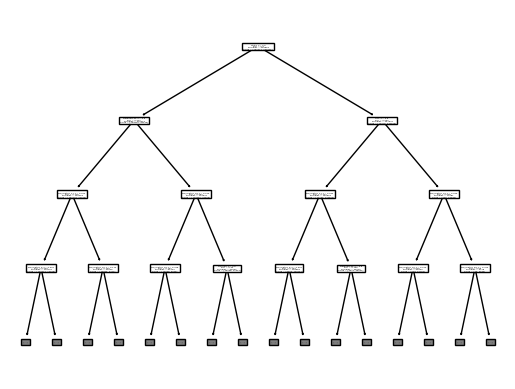

In [32]:
%%time
from sklearn import tree
tree.plot_tree(dt, 
              feature_names = list(X_train.columns),
              max_depth = 3)

In [33]:
feature_names

Index(['City', 'State', 'Country', 'DegreeType', 'WorkHistoryCount',
       'TotalYearsExperience', 'CurrentlyEmployed', 'ManagedOthers',
       'ManagedHowMany', 'work_matrix_0',
       ...
       'job_matrix_90', 'job_matrix_91', 'job_matrix_92', 'job_matrix_93',
       'job_matrix_94', 'job_matrix_95', 'job_matrix_96', 'job_matrix_97',
       'job_matrix_98', 'job_matrix_99'],
      dtype='object', length=159)

In [34]:
# Get text representation
from sklearn.tree import DecisionTreeClassifier
text_dt = tree.export_text(dt, max_depth=5, feature_names=list(feature_names))
print(text_dt)

|--- State <= 0.50
|   |--- DegreeType <= 3.50
|   |   |--- job_matrix_21 <= 0.02
|   |   |   |--- job_matrix_8 <= 0.03
|   |   |   |   |--- City <= 0.50
|   |   |   |   |   |--- job_matrix_7 <= 0.22
|   |   |   |   |   |   |--- truncated branch of depth 104
|   |   |   |   |   |--- job_matrix_7 >  0.22
|   |   |   |   |   |   |--- truncated branch of depth 56
|   |   |   |   |--- City >  0.50
|   |   |   |   |   |--- job_matrix_18 <= 0.15
|   |   |   |   |   |   |--- truncated branch of depth 12
|   |   |   |   |   |--- job_matrix_18 >  0.15
|   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |--- job_matrix_8 >  0.03
|   |   |   |   |--- City <= 0.50
|   |   |   |   |   |--- job_matrix_27 <= 0.01
|   |   |   |   |   |   |--- truncated branch of depth 59
|   |   |   |   |   |--- job_matrix_27 >  0.01
|   |   |   |   |   |   |--- truncated branch of depth 54
|   |   |   |   |--- City >  0.50
|   |   |   |   |   |--- job_matrix_96 <= 0.05
|   |   |   |   |   |   |--- tr

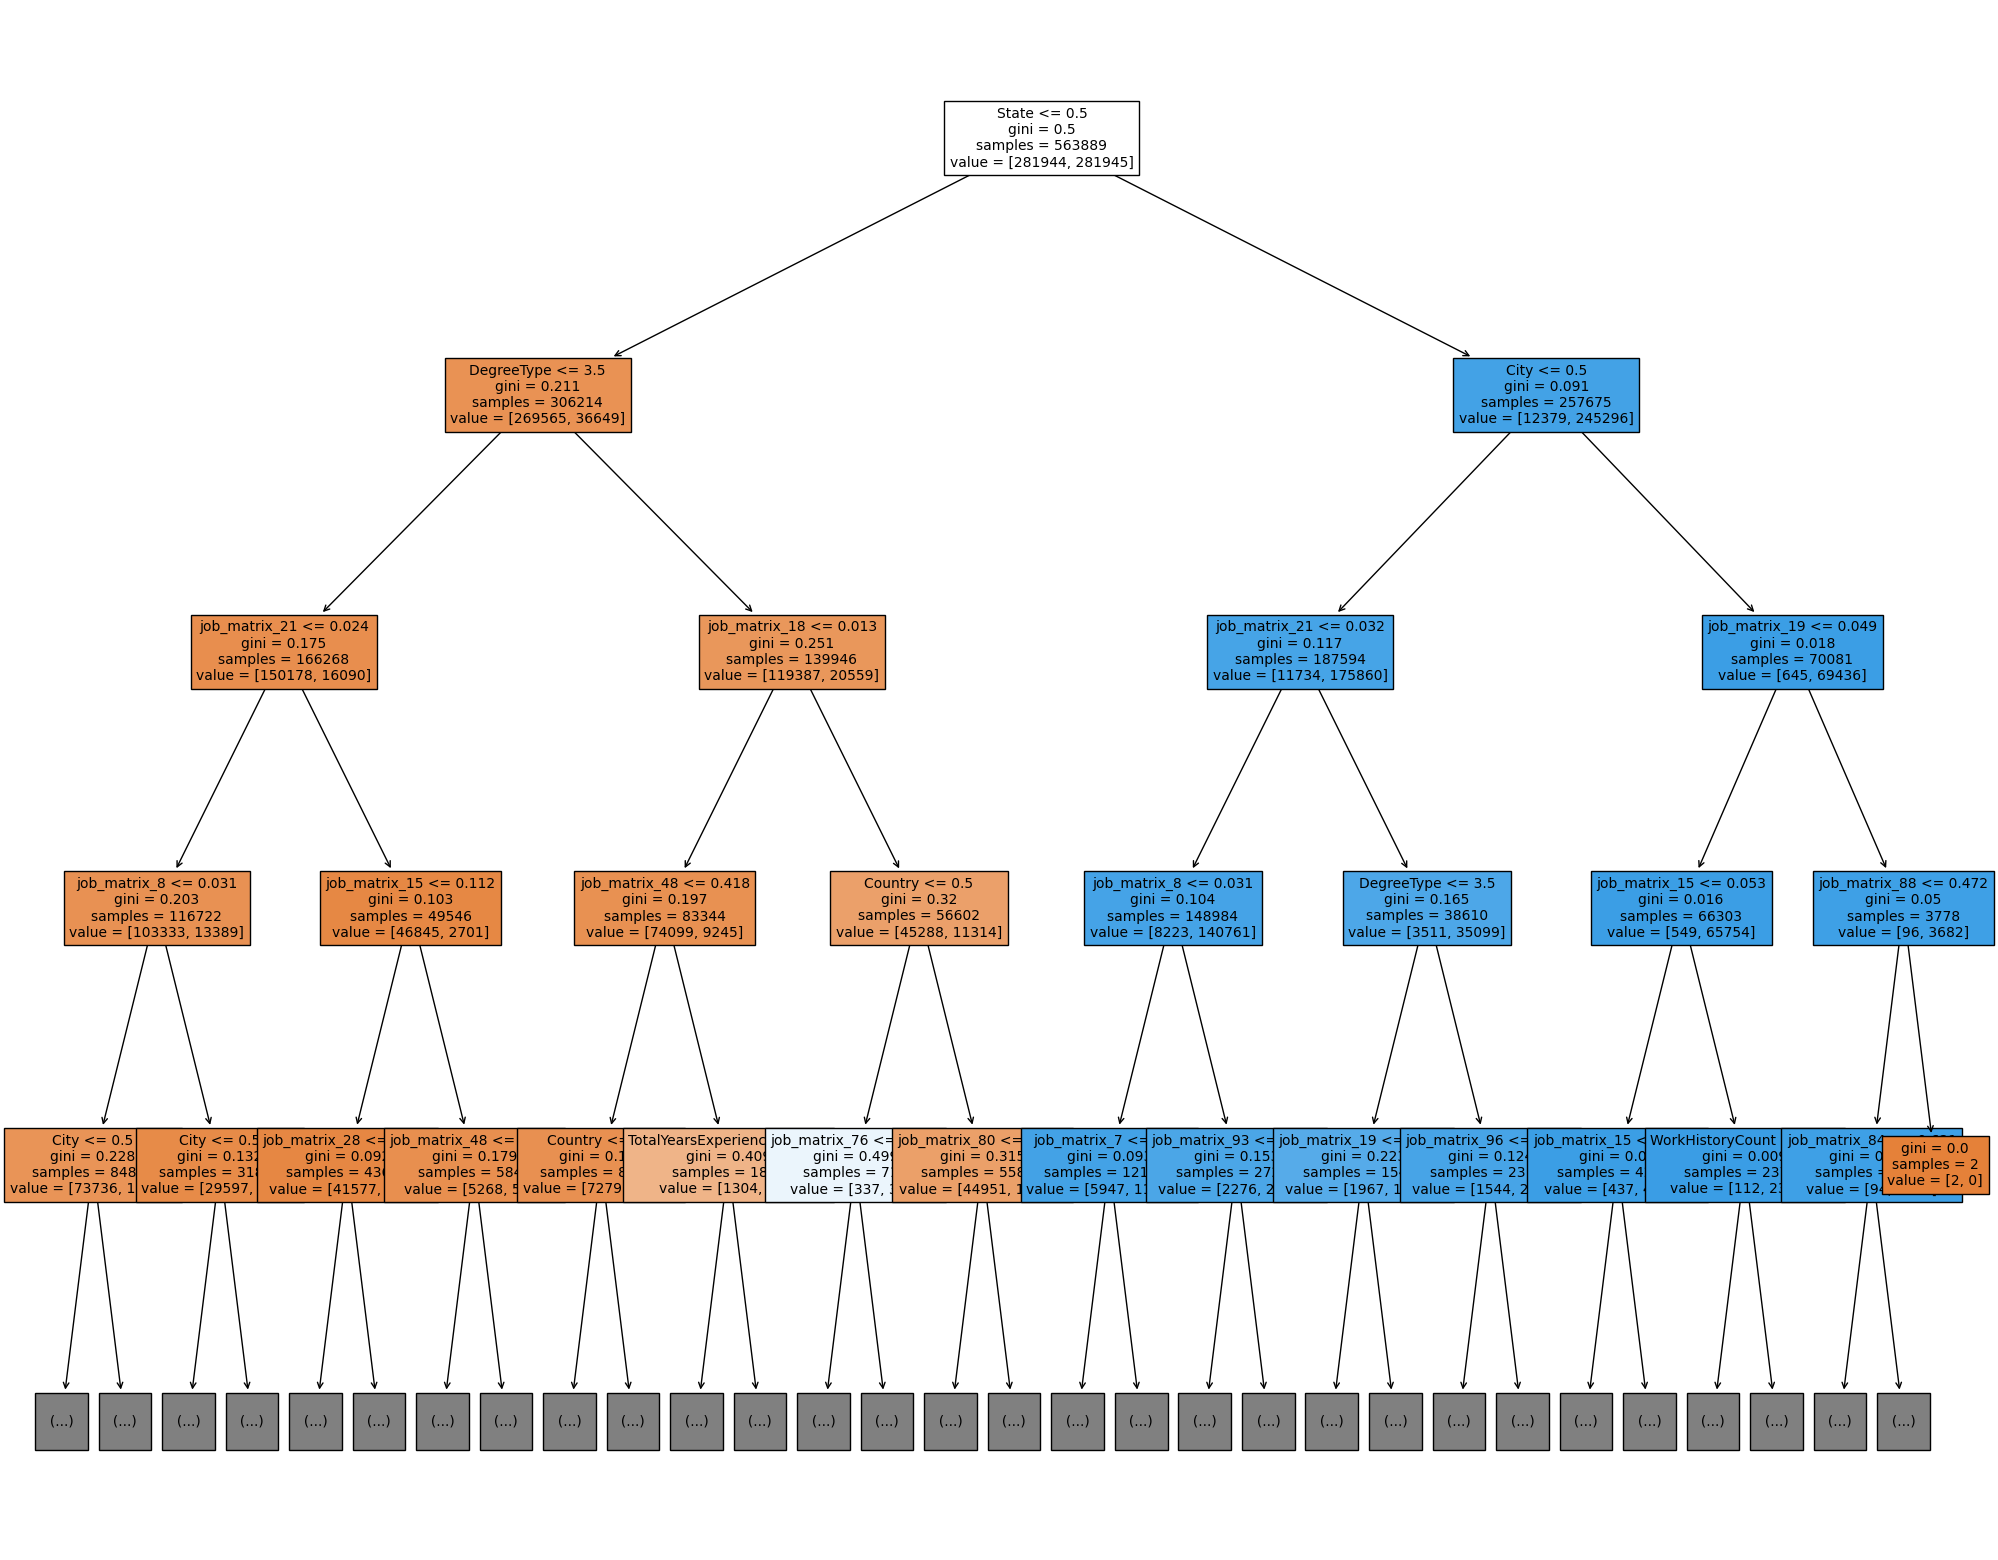

In [35]:
# Plot the decision tree (max_depth = 5)
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(dt, max_depth = 4,
                   feature_names=list(feature_names),  
                   filled=True,
                  fontsize=10)
plt.savefig('./output_baseline_tabular/DT_flat_high_dpi', dpi=100)

## 3. Model: XGBoost (XGBT)

In [36]:
# Load a baseline model
import pickle
model = 'xgbt'
model_name = './output_baseline_tabular/cb12_xgbt_flat.pikle'
xgbt = pickle.load(open(model_name, "rb"))

[18:45:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.



[0.00150503 0.994291   0.         0.00215121 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00205281 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         

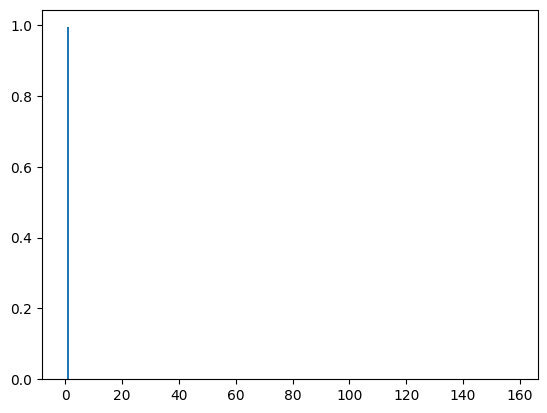

In [37]:
# feature importance
print(xgbt.feature_importances_)
# plot
plt.bar(range(len(xgbt.feature_importances_)), xgbt.feature_importances_)
plt.show()

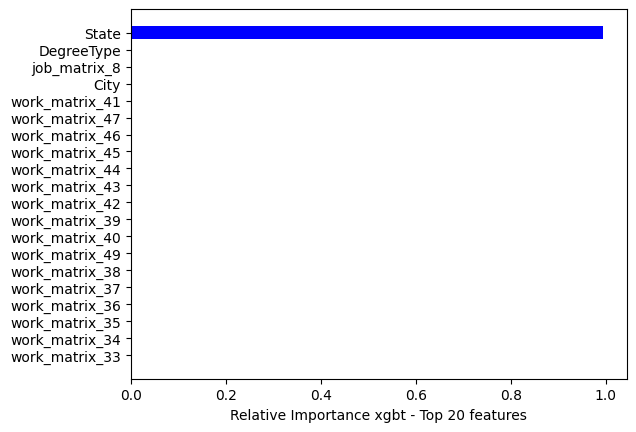

In [38]:
# only plot the customized number of features
importances = xgbt.feature_importances_
indices = np.argsort(importances)
num_features = 20
plt.barh(range(num_features), importances[indices[-num_features:]], color='b', align='center')
plt.yticks(range(num_features), [feature_names[i] for i in indices[-num_features:]])
plt.xlabel(f'Relative Importance {model} - Top 20 features')
plt.show()

In [39]:
xgbt_fi = pd.DataFrame(columns=['features','importance'])

In [40]:
xgbt_fi.features = [feature_names[i] for i in indices[-num_features:]]

In [41]:
xgbt_fi.importance = importances[indices[-num_features:]]

In [42]:
xgbt_fi

,features,importance
0,work_matrix_33,0.000000
1,work_matrix_34,0.000000
2,work_matrix_35,0.000000
3,work_matrix_36,0.000000
4,work_matrix_37,0.000000
5,work_matrix_38,0.000000
6,work_matrix_49,0.000000
7,work_matrix_40,0.000000
8,work_matrix_39,0.000000
9,work_matrix_42,0.000000


In [43]:
xgbt_fi.to_csv('./xai_posthoc/xgbt_global_exp.csv', header=True, index=False)